### Dispenser Usage Analysis

#### Background
- Detecting Hand Hygiene Dispenser Use
- See: https://docs.google.com/document/d/1iPzdrs4tEbltL9iHykD_KKQxFjcWRBDu5fH6YkuxFFM/edit

#### Notebook
This notebook creates time-based saliency maps to try to better understand the behavior of the dispenser usage model predcitions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://aicare.stanford.edu/sep2020.tar.gz

--2020-09-18 04:00:31--  https://aicare.stanford.edu/sep2020.tar.gz
Resolving aicare.stanford.edu (aicare.stanford.edu)... 171.64.68.86
Connecting to aicare.stanford.edu (aicare.stanford.edu)|171.64.68.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224617454 (214M) [application/x-gzip]
Saving to: ‘sep2020.tar.gz’

sep2020.tar.gz      100%[===================>] 214.21M  2.74MB/s    in 75s     

2020-09-18 04:01:46 (2.85 MB/s) - ‘sep2020.tar.gz’ saved [224617454/224617454]



In [3]:
!tar -xzf sep2020.tar.gz

In [ ]:
!ls hh_data

labels.json  mp4  npy


In [ ]:
!nvidia-smi

Thu Sep 17 19:02:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [54]:
# Load original model
model = tf.keras.models.load_model('drive/My Drive/svl-pac/checkpoints/dispenser-v7/cp-0027.ckpt')
model.trainable = False
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 240, 320, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 8, 10, 2048)   23587712  
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 24, 8, 10, 64)     4866304   
_________________________________________________________________
global_average_pooling3d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 28,454,146
Trainable params: 0
Non-trainable params: 28,454,146
_________________________________________________________________


In [52]:
model.get_layer("dense_2").activation

<function tensorflow.python.keras.activations.softmax>

In [15]:
!pip install tf-keras-vis

In [88]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tf_keras_vis import ModelVisualization
from tf_keras_vis.utils import check_steps, listify

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# Adapted from https://github.com/keisen/tf-keras-vis/blob/master/tf_keras_vis/saliency.py
class CustomSaliency(ModelVisualization):
    def __call__(self,
                 seed_input,
                 label,
                 smooth_samples=0,
                 smooth_noise=0.20,
                 keepdims=True,
                 gradient_modifier=lambda grads: K.abs(grads)):
        # Preparing
        seed_inputs = tf.convert_to_tensor(seed_input, dtype=tf.float32)
        # Processing saliency
        if smooth_samples > 0:
            axis = tuple(range(1, len(seed_inputs.shape)))
            sigmas = smooth_noise * (np.max(seed_inputs, axis=axis) - np.min(seed_inputs, axis=axis))
            total_gradients = np.zeros_like(seed_inputs)
            for i in range(check_steps(smooth_samples)):
                print(f"Running step {i}")
                seed_inputs_plus_noise = tf.constant(
                        np.concatenate([
                            x + np.random.normal(0., s, (1, ) + x.shape) for x, s in zip(seed_inputs, sigmas)
                        ])
                )

                gradients = self._get_gradients(seed_inputs_plus_noise, gradient_modifier, label)
                total_gradients = total_gradients + gradients[0]
            grads = total_gradients / smooth_samples
        else:
            grads = self._get_gradients(seed_inputs, gradient_modifier, label)
            # print(grads)

        # Visualizing
        if not keepdims:
            grads = [np.max(g, axis=-1) for g in grads]
        if len(self.model.inputs) == 1 and not isinstance(seed_input, list):
            grads = grads[0]
        return grads

    # Define loss function. 
    def loss(self, output, label):
        # 0 is positive, 1 is neutral, 2 is negative
        return (output[0, label - 1])

    def _get_gradients(self, seed_inputs, gradient_modifier, label):
        with tf.GradientTape() as tape:
            tape.watch(seed_inputs)
            outputs = self.model(seed_inputs)
            loss_values = self.loss(outputs, label)
            grads = tape.gradient(loss_values, seed_inputs)
        if gradient_modifier is not None:
            grads = [gradient_modifier(g) for g in grads]
        return grads

In [18]:
import json
from os.path import isfile, join, exists

video_to_room = {}
video_to_class = {}
with open("hh_data/labels.json", "r") as f:
    labels_obj = json.load(f)
    for k, v in labels_obj.items():
        video_to_room[k] = v["room"]
        video_to_class[k] = v["is_clean"]
classes = list(set(video_to_class.values()))

video_ids = []
frame_numbers = []
# Because some videos are being held back, we are just going to filter for videos we know about
for k in video_to_class.keys():
    if exists("hh_data/npy/" + k + ".npy"):
        video_ids.append(k)
        video_obj = np.load("hh_data/npy/" + k + ".npy")
        frame_numbers.append(video_obj.shape[0])
print(f"Max frames: {np.max(frame_numbers)}")
print(f"Min frames: {np.min(frame_numbers)}")
print(f"Avg frames: {np.mean(frame_numbers)}")
print(f"Avg frames: {np.median(frame_numbers)}")


Max frames: 200
Min frames: 5
Avg frames: 32.562913907284766
Avg frames: 25.0


### Explore Saliency of Correct Predictions
- Note the gradients around the outside of the objects

Actual Class: 1
Predicted Class: [[0.01179535 0.9882046 ]]


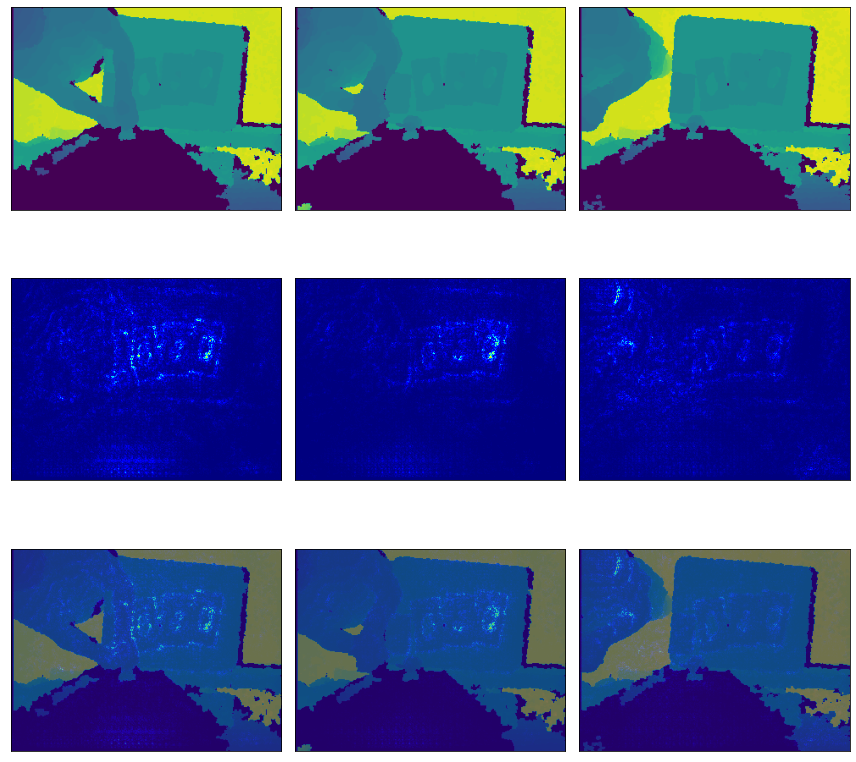

In [89]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

NUM_FRAMES = 24
BATCH_SIZE = 16
IMG_HEIGHT = 240
IMG_WIDTH = 320

def vid_normalize(a):
    return (255*(a/np.max(a))).astype(int)

def tensor_normalize(a):
    return (255*(a.numpy()/np.max(a.numpy()))).astype(int)

def get_x(model, video_id):
    video = np.load(f"hh_data/npy/{video_id}.npy")

    curr_frames = video.shape[0]

    # Convert npy to float32 to avoid processing problems
    # NUM_FRAMES, 240, 320
    base_video = np.zeros((NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

    # Number of frames are uneven, so we will evenly sample across all video frames
    # if the number of frames are more than the frames we want to use
    if NUM_FRAMES < curr_frames:
        indices = np.round(np.linspace(0, curr_frames - 1, NUM_FRAMES)).astype(int)
        base_video[:, :, :] = video[indices, :, :]
    else:
        base_video[:min(curr_frames, NUM_FRAMES), :, :] = video[:min(curr_frames, NUM_FRAMES), :, :].astype(np.float32)

    # Repeat the depth image three times to simulate RGB
    video = base_video[:, :, :, np.newaxis]
    video = vid_normalize(video)
    video = np.repeat(video, 3, -1)

    X = np.expand_dims(video, axis=0)
    return X, video

def render_saliency_map(model, video_id, offset, layer=0):
    X, video = get_x(model, video_id)

    # Create Saliency object
    saliency = CustomSaliency(model, model_modifier=model_modifier, clone=False)

    # Generate saliency map
    # print(X.shape)
    saliency_map = saliency(X, video_to_class[video_id], smooth_samples=0)
    saliency_map = normalize(saliency_map)
    # print(saliency_map.shape)

    subprot_args = {
        'nrows': 3,
        'ncols': 3,
        'figsize': (12, 12),
        'subplot_kw': {'xticks': [], 'yticks': []}
    }

    print("Actual Class: " + str(video_to_class[video_id]))

    print("Predicted Class: " + str(model.predict(X)))

    f, ax = plt.subplots(**subprot_args)
    frames_to_disp = 3
    for i in range(frames_to_disp):
        ax[0, i].imshow(video[offset + i, :, :, 0])
        ax[1, i].imshow(tensor_normalize(saliency_map[offset + i, :, :, layer]), cmap='jet')
        ax[2, i].imshow(video[offset + i, :, :, 0])
        ax[2, i].imshow(tensor_normalize(saliency_map[offset + i, :, :, layer]), cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()

render_saliency_map(model, video_id="001", offset=8)

Actual Class: 1
Predicted Class: [[0.01767962 0.9823203 ]]


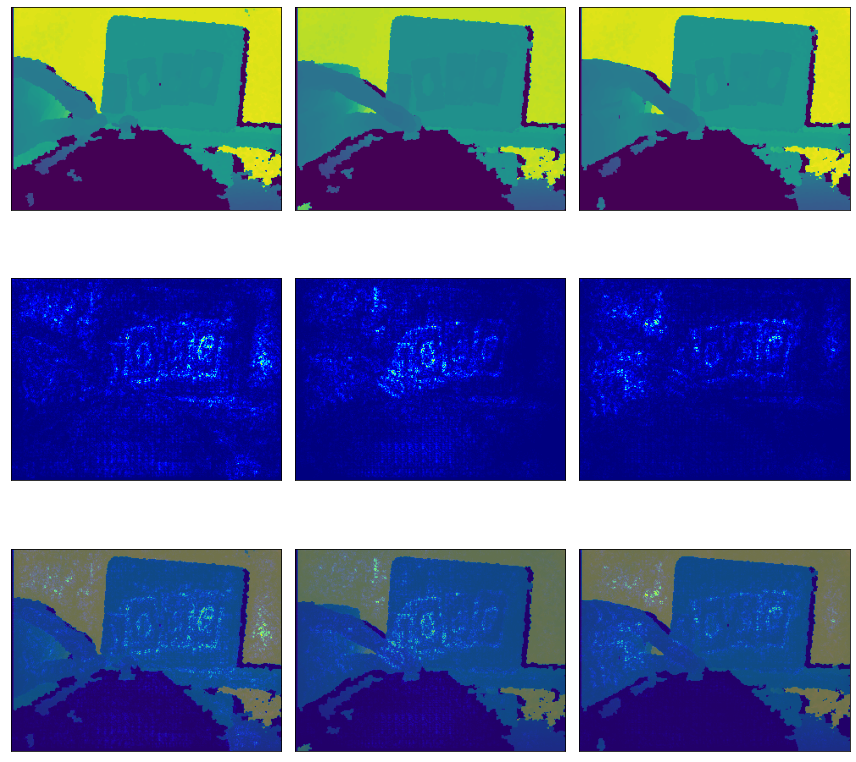

In [60]:
render_saliency_map(model, video_id="003", offset=5)

Actual Class: 1
Predicted Class: [[0.01767962 0.9823203 ]]


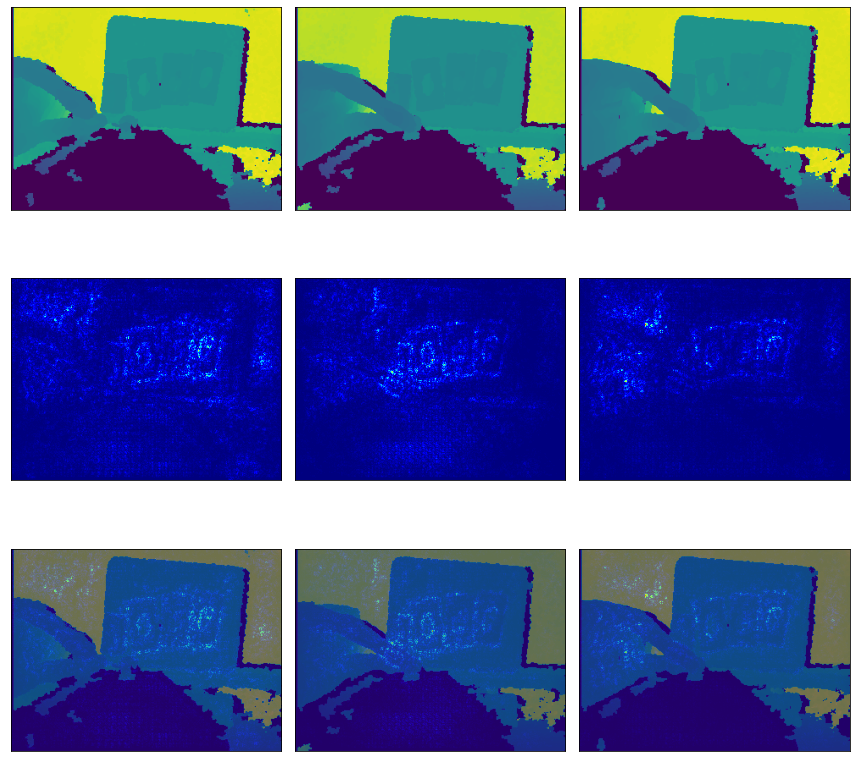

In [90]:
render_saliency_map(model, video_id="003", offset=5)

### Get Videos Labeled Incorrectly

In [80]:
import os
from tqdm import tqdm

files = next(os.walk(f"hh_data/npy/"))[2]
for f in tqdm(files):
    vid_id = f.split(".")[0]
    X, _ = get_x(model, video_id=vid_id)
    actual = video_to_class[vid_id]
    sig = model(X)[0]
    if sig[0] > sig[1]:
        pred = 0
    else:
        pred = 1
    if actual != pred:
        print("Wrong: " + vid_id)

  3%|▎         | 8/302 [00:03<02:08,  2.30it/s]

Wrong: 026


 13%|█▎        | 38/302 [00:16<01:42,  2.58it/s]

Wrong: 018


 20%|█▉        | 59/302 [00:25<01:41,  2.39it/s]

Wrong: 375


 22%|██▏       | 67/302 [00:28<01:40,  2.35it/s]

Wrong: 040


 24%|██▎       | 71/302 [00:30<01:26,  2.66it/s]

Wrong: 013


 30%|██▉       | 90/302 [00:37<01:27,  2.42it/s]

Wrong: 044


 30%|███       | 91/302 [00:38<01:24,  2.51it/s]

Wrong: 270


 35%|███▌      | 107/302 [00:45<01:27,  2.23it/s]

Wrong: 306


 37%|███▋      | 112/302 [00:48<01:54,  1.65it/s]

Wrong: 078


 42%|████▏     | 126/302 [00:54<01:20,  2.18it/s]

Wrong: 027


 42%|████▏     | 127/302 [00:55<01:32,  1.89it/s]

Wrong: 309


 46%|████▌     | 138/302 [01:01<01:29,  1.83it/s]

Wrong: 452


 52%|█████▏    | 157/302 [01:09<01:08,  2.11it/s]

Wrong: 351


 53%|█████▎    | 159/302 [01:10<01:04,  2.22it/s]

Wrong: 035


 57%|█████▋    | 171/302 [01:15<00:49,  2.67it/s]

Wrong: 085


 78%|███████▊  | 237/302 [01:45<00:32,  1.98it/s]

Wrong: 091


 93%|█████████▎| 282/302 [02:05<00:09,  2.06it/s]

Wrong: 048


 97%|█████████▋| 293/302 [02:10<00:04,  2.13it/s]

Wrong: 132


 99%|█████████▉| 299/302 [02:13<00:01,  2.21it/s]

Wrong: 077


100%|██████████| 302/302 [02:15<00:00,  2.23it/s]


### Failure Case 1

Model predicted "clean" even though correct label should be "not clean".
- Could be mislabled?
- Poor activations on hand, some activation on body

Actual Class: 0
Predicted Class: [[0.05993813 0.94006187]]


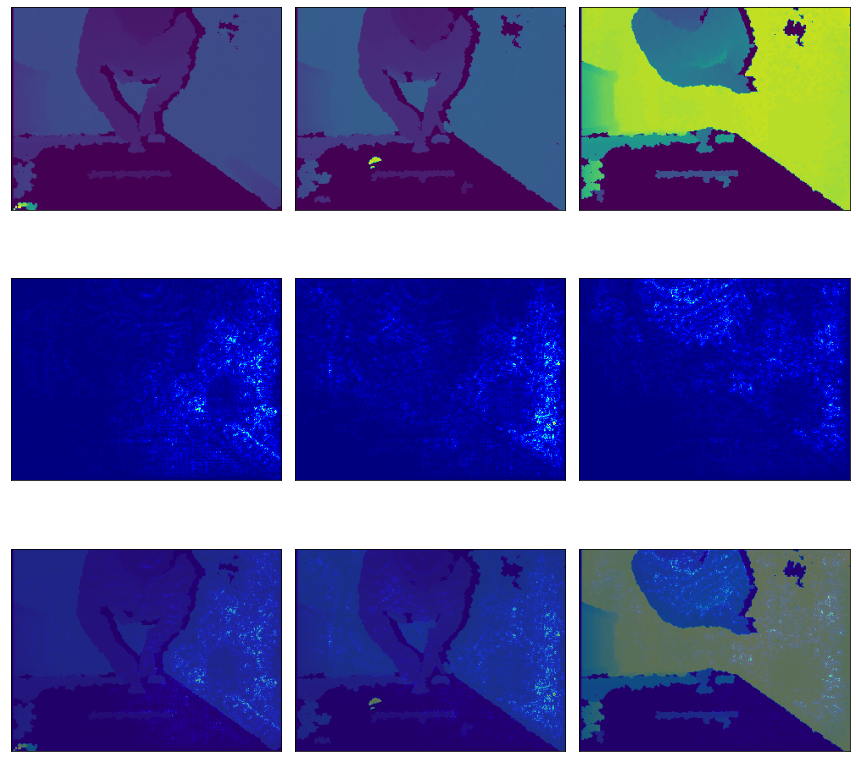

In [101]:
render_saliency_map(model, video_id="309", offset=7)

### Failure Case 2

Model predicted "not clean" even though it should be "clean". 

- Could be a result of activation on the body, instead of the hand, since there are other videos like `366` which have people passing by in the same position without getting sanitizer.

Actual Class: 1
Predicted Class: [[0.6904359 0.3095641]]


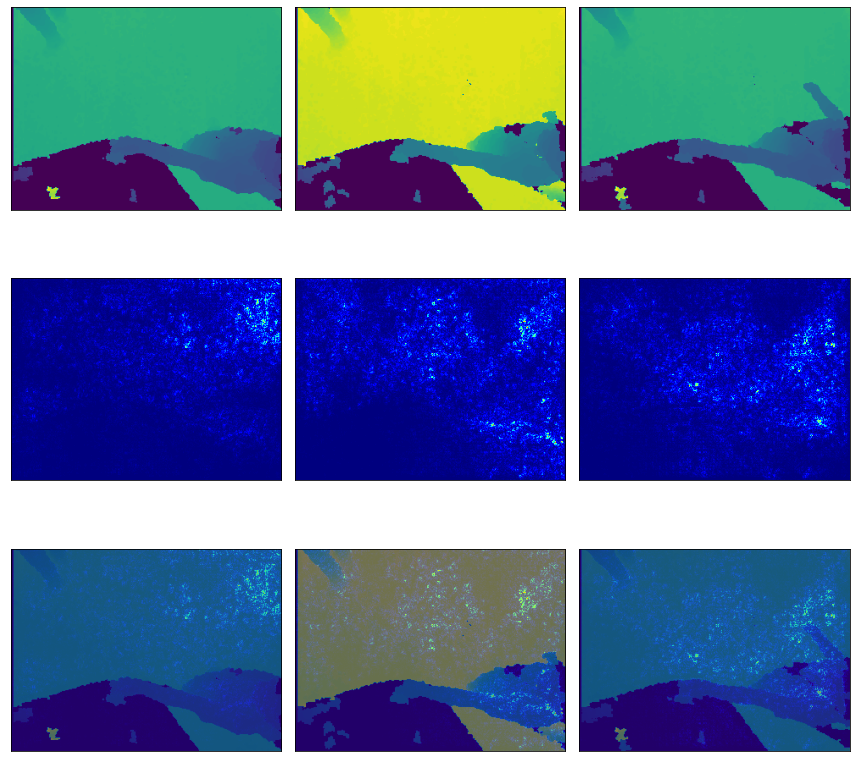

In [96]:
render_saliency_map(model, video_id="375", offset=6)

Actual Class: 1
Predicted Class: [[0.0842275 0.9157725]]


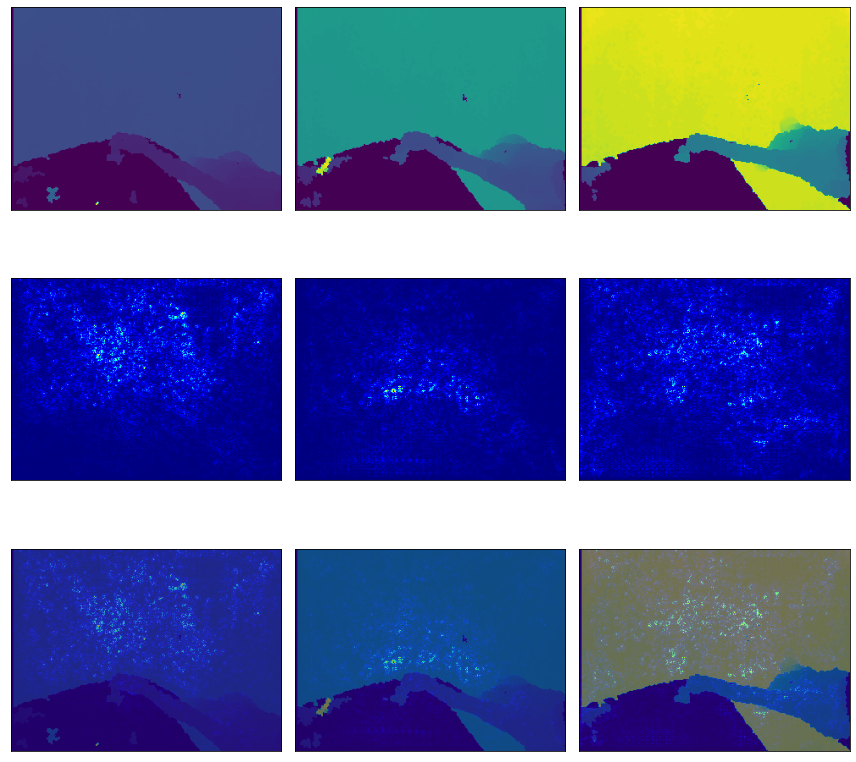

In [95]:
render_saliency_map(model, video_id="369", offset=4)